In [10]:
import torch
import numpy as np
import random as rd
import torch.nn as nn
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from model import LPGCN
from generate_data import generate_random_linear_program, solve_linear_program, generate_and_solve_batches
from scipy.optimize import linprog

In [11]:
def train(model, c, A, b, constraint, l, u, sol, feas, out_func, optimizer):
    optimizer.zero_grad()
    out = model(c, A, b, constraint, l, u, out_func)

    loss = nn.MSELoss()
    if out_func == 'feas':
        loss = loss(out, feas)

    elif out_func == 'obj':
        #loss = loss(out, (c[:, None, :] @ sol[:, :, None])[:,0])
        loss = loss(out[:,0], torch.sum(c * sol, dim=1))

    else:
        loss = loss(out, sol)

    loss.backward()
    optimizer.step()
    return loss

def test(model, c, A, b, constraint, l, u, sol, feas, out_func):
    out = model.forward(c, A, b, constraint, l, u, out_func)
    loss = nn.MSELoss()
    if out_func == 'feas':
        loss = loss(out, feas)
    elif out_func == 'obj':
        loss = loss(out, c.T @ sol)
    else:
        loss = loss(out, sol)
    return loss

In [12]:
### PARAMETERS ###
num_constraints = 2
num_variables = 5
batch_size = 64
learning_rate = 0.003
num_data = 300
out_func = 'obj'

device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs = 50

In [13]:
def gen_data(num_data, batch_size, num_variables, num_constraints, out_func):
    data = []
    for i in range(num_data):
        c, A, b, constraints, l, u, solution, feasibility = generate_and_solve_batches(batch_size,
                                                                                    num_variables,
                                                                                    num_constraints,
                                                                                    out_func)
        data.append([c, A, b, constraints, l, u, solution, feasibility])
    return data

In [14]:
def train(train_data, val_data, out_func, epochs, num_constraints, num_variables):
    model = LPGCN(num_constraints, num_variables).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    val_loss = []
    
    def unpack_vars(data):
        c, A, b, constraints, l, u, sol, feas = data
        c = c.to(device)
        A = A.to(device)
        b = b.to(device)
        constraints = constraints.to(device)
        l = l.to(device)
        u = u.to(device)
        sol = sol.to(device)
        return c, A, b, constraints, l, u, sol, feas
    
    # optimize parameters and calculates training loss
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        aux = 0

        for batch in train_data:
            c, A, b, constraints, l, u, sol, feas = unpack_vars(batch)
            optimizer.zero_grad()
            out = model(c, A, b, constraints, l, u, out_func)
            if out_func == 'feas':
                loss = (out.shape[0] - torch.sum(torch.eq(out, feas))) / out.shape[0]
                # print(loss)

            elif out_func == 'obj':
                loss = criterion(out[:,0], torch.sum(c * sol, dim=1))

            else:
                loss = criterion(out, sol)

            if out_func != 'feas':
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            aux += 1

        train_loss += [running_loss]
        
        # backup of optimized parameters
        if not os.path.exists('model_backups'):
            os.makedirs('model_backups')

        torch.save(model.state_dict(), f'model_backups/params_{epoch}.pt')
        
        # calculates validation error
        running_loss = 0.0
        for data in val_data:
            c, A, b, constraints, l, u, sol, feas = unpack_vars(batch)
            if out_func == 'feas':
                loss = (out.shape[0] - torch.sum(torch.eq(out, feas))) / out.shape[0]
                # print(loss)

            elif out_func == 'obj':
                loss = criterion(out[:,0], torch.sum(c * sol, dim=1))

            else:
                loss = criterion(out, sol)

            running_loss += loss.item()

        val_loss += [running_loss]
    
    return train_loss, val_loss

In [15]:
train_data_feas = gen_data(int(num_data*0.5), batch_size, num_variables, num_constraints, out_func)
val_data_feas = gen_data(int(num_data*0.3), batch_size, num_variables, num_constraints, out_func)
test_data_feas = gen_data(int(num_data*0.2), batch_size, num_variables, num_constraints, out_func)

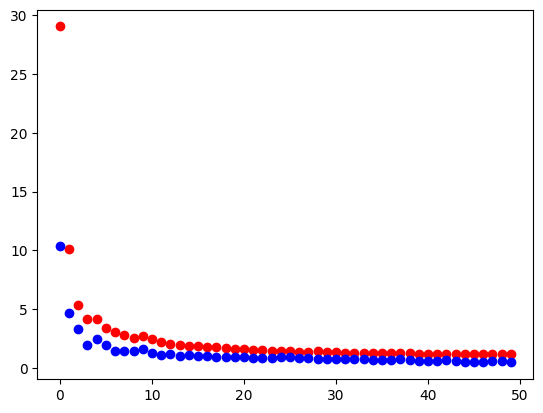

In [16]:
epochs = 50

train_loss, val_loss = train(train_data_feas, val_data_feas, out_func, epochs, num_constraints, num_variables)

x = [i for i in range(epochs)]

plt.plot(x, train_loss, 'o', color='red')
plt.plot(x, val_loss, 'o', color='blue')
plt.show()

In [17]:
# training model
print("\n\n")
print("Training model")
print("\n\n")
pbar = tqdm(range(epochs))
for epoch in pbar:
    for batch in data_train:
        c, A, b, constraints, l, u, sol, feas = batch
        c = c.to(device)
        A = A.to(device)
        b = b.to(device)
        constraints = constraints.to(device)
        l = l.to(device)
        u = u.to(device)
        sol = sol.to(device)
        feas = feas
        loss = train(model, c, A, b, constraints, l, u, sol, feas, out_func, optimizer)
        pbar.set_description(f"%.8f" % loss)




Training model





  0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'data_train' is not defined

In [ ]:
# Test model
print("\n\n")
print("Testing model")
print("\n\n")
batch_size = 5
M = 10

data_test = []
for i in range(M):
    c, A, b, constraints, l, u, solution, feasibility = generate_and_solve_batches(batch_size,
                                                                                   num_variables,
                                                                                   num_constraints,
                                                                                   out_func)
    data_test.append([c, A, b, constraints, l, u, solution, feasibility])

for batch in data_test:
    c, A, b, constraints, l, u, sol, feas = batch
    c = c.to(device)
    A = A.to(device)
    b = b.to(device)
    constraints = constraints.to(device)
    l = l.to(device)
    u = u.to(device)
    sol = sol.to(device)
    feas = feas.to(device)

    loss = test(model, c, A, b, constraints, l, u, sol, feas, out_func)
    print(f"Loss: {loss}")

In [ ]:
model2 = LPGCN(num_constraints, num_variables).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Test model
print("\n\n")
print("Testing model")
print("\n\n")
batch_size = 5
M = 10

data_test = []
for i in range(M):
    c, A, b, constraints, l, u, solution, feasibility = generate_and_solve_batches(batch_size,
                                                                                   num_variables,
                                                                                   num_constraints,
                                                                                   out_func)
    data_test.append([c, A, b, constraints, l, u, solution, feasibility])

def test(model, c, A, b, constraint, l, u, sol, feas, out_func):
    out = model.forward(c, A, b, constraint, l, u, out_func)
    loss = nn.MSELoss()
    if out_func == 'feas':
        loss = loss(out, feas)
    elif out_func == 'obj':
        loss = loss(out, c.T @ sol)
    else:
        loss = loss(out, sol)
    return loss


for batch in data_test:
    c, A, b, constraints, l, u, sol, feas = batch
    c = c.to(device)
    A = A.to(device)
    b = b.to(device)
    constraints = constraints.to(device)
    l = l.to(device)
    u = u.to(device)
    sol = sol.to(device)
    feas = feas.to(device)

    loss = test(model2, c, A, b, constraints, l, u, sol, feas, out_func)
    print(f"Loss: {loss}")

## Running tests

In [ ]:
#if not os.path.exists('gnn_backup'):os.makedirs('gnn_backup')

        
#torch.save(cnn.state_dict(), f'cnn_backup/bkp_e{epoch}.pt')
#opt_cnn.load_state_dict(torch.load(f'cnn_backup/bkp_{opt_idx}.pt')) 

In [ ]:
if not os.path.exists('gnn_backup'):os.makedirs('gnn_backup')

In [ ]:
### PARAMETERS ###
num_constraints = 2
num_variables = 5
batch_size = 10
learning_rate = 0.003
N = 100
out_func = 'obj'

device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LPGCN(num_constraints, num_variables).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#epochs = 200
#pbar = tqdm(range(epochs))

In [ ]:
data_train = []
for i in range(N):
    c, A, b, constraints, l, u, solution, feasibility = generate_and_solve_batches(batch_size,
                                                                                   num_variables,
                                                                                   num_constraints,
                                                                                   out_func)
    data_train.append([c, A, b, constraints, l, u, solution, feasibility])

In [ ]:
epochs = 10
s = 0

for _ in range(5):
    s += epochs
    pbar = tqdm(range(epochs))

    for epoch in pbar:
        for batch in data_train:
            c, A, b, constraints, l, u, sol, feas = batch
        
            c = c.to(device)
            A = A.to(device)
            b = b.to(device)
            constraints = constraints.to(device)
            l = l.to(device)
            u = u.to(device)
            sol = sol.to(device)
            feas = feas
        
            loss = train(model, c, A, b, constraints, l, u, sol, feas, out_func, optimizer)
            pbar.set_description(f"%.8f" % loss)
    
    torch.save(model.state_dict(), f'gnn_backup/bkp_obj_{s}.pt')